# Lecture 5. Model Selection, Polynomial Regresssion
--- 

### CS 109A/AC 209A/STAT 121A Data Science:
### Harvard University
Fall 2016 <br>
Instructors:  P. Protopapas, K. Rader, W. Pan




<br>

# Announcements 

- Back to Nortwest Building Room B103
- HW1: You should have received grades back. No regrading requests! Good results 
- HW2: Is due tonight (11:59pm)  
- HW3: will be posted  **after** the lecture



 - No re-grading, no discussions about grades unless you believe there is a technical mistake in grading. 
      <br>
      GRADES ARE FINAL 
 

In [374]:
import sys
import time

def countdown(n):
    #print("QUIZ TIME")
    for i in range(60*n,0,-1):
        time.sleep(1)
        sys.stdout.write(str(i)+' ')
        sys.stdout.flush()

# QUIZ TIME
{{countdown(1)}}

In [210]:
from ipywidgets import interact,  FloatSlider, RadioButtons
import numpy as np 
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as Lin_Reg

import statsmodels.api as sm
import pandas as pd
    
from mpl_toolkits.mplot3d import Axes3D

In [211]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

<br>

# Outline 
- ** Select among multiple predictors **
    - Forward, Backward, Hybrid
    - AIC, BIC, reduced R2, Cp 
- Polynomial regression
    - Formalism 
    - Select the degree 

- Revisit SE, p-value and all that jazz  
   

    


<br>
## Multiple predictors
- We will use the  "bloodpressure" example from last lecture
- Systolic Blood pressure as a function of age, height, weight 


Select the best subset of predictors out of many 


** Exhausitive Algorithm: **

Let $M_p$ be all models containing $p$ predictors

1. Fit a separate least squares regression of all possible $M_p$ 
2. Pick the best of $M_p$. Best as the one with the highest $R^2$ 
3. Select a single best model from among $M_p$ using AIC, BIC or adjusted $R^2$
    

- M0: `null`
- M1: `age, height, weight` 
- M2: `(age+height), (age+weight), (height+weight)`
- M3: `(age+weight+height) `

In [375]:


#  IMPORT DATA 
dt = pd.read_csv("bloodpressure_male.csv")
age=dt['age'].values
weight=dt['weight'].values
height=dt['height'].values
blood=dt['bloodpressure'].values

In [324]:

data=dt.values.T
X = data[:-1]
Y=data[-1]
Y.shape

(120,)

In [325]:

# Run all possible combibations and examine the R2 
p=X.shape[0]
R2 = np.zeros((2**p))
RSE = np.zeros((2**p))
AIC = np.zeros((2**p))
BIC = np.zeros((2**p))
RedR2 = np.zeros((2**p))

R2best = np.zeros((p,2)) 


model_counter =0
for k in np.arange(p):
    Xt = sm.add_constant(X[k])
    model=sm.OLS(Y,Xt)
    model_results=model.fit()
    model_counter +=1
    R2[model_counter]=model_results.rsquared
    AIC[model_counter]=model_results.aic
    BIC[model_counter]=model_results.bic
    RedR2[model_counter]=model_results.rsquared_adj

R2best[0,0]=np.max(R2)  
R2best[0,1]=np.argmax(R2)

for k in np.arange(p-1):
    for kp in np.arange(k+1,p):
        Xt = sm.add_constant(X[k:k+2, :].T)
        model=sm.OLS(Y,Xt)
        model_results=model.fit()
        model_counter +=1
        R2[model_counter]=model_results.rsquared
        AIC[model_counter]=model_results.aic
        BIC[model_counter]=model_results.bic
        RedR2[model_counter]=model_results.rsquared_adj

R2best[1,0]=np.max(R2[4:7])
R2best[1,1]=np.argmax(R2[4:7])+4
       
for k in np.arange(p-2):
    for kp in np.arange(k+2,p):
        Xt = sm.add_constant(X[k:k+3, :].T)
        model=sm.OLS(Y,Xt)
        model_results=model.fit()
        model_counter +=1
        R2[model_counter]=model_results.rsquared
        AIC[model_counter]=model_results.aic
        BIC[model_counter]=model_results.bic
        RedR2[model_counter]=model_results.rsquared_adj
        
R2best[2,0]=np.max(R2[7])
R2best[2,1]=np.argmax(R2[7])+7
# THE FOLLOWING IS FOR THE MARKDOWN TABLE 
#for i in np.arange(np.size(R2)):    print( "{{math.ceil(R2[",i,"]*1000)/1000}}  | ",  end="")
#for i in np.arange(3):    print( "{{math.ceil(AIC[",int(R2best[i,1]),"]*1000)/1000}}  | ",  end="")
#for i in np.arange(3):    print( "{{math.ceil(BIC[",int(R2best[i,1]),"]*1000)/1000}}  | ",  end="")
for i in np.arange(3):    print( "{{math.ceil(RedR2[",int(R2best[i,1]),"]*1000)/1000}}  | ",  end="")

{{math.ceil(RedR2[ 1 ]*1000)/1000}}  | {{math.ceil(RedR2[ 4 ]*1000)/1000}}  | {{math.ceil(RedR2[ 7 ]*1000)/1000}}  | 

<br>
We fit linear model for all of them. 

| | null | age | weight | height | age+weight | age+height | weight+height | age+weight+height |
| ---| :---:|| :---:|| :---:|| :---:|| :---:|| :---:|| :---:|| :---:| 
| $R^2$ |{{math.ceil(R2[ 0 ]*1000)/1000}}  | {{math.ceil(R2[ 1 ]*1000)/1000}}  | {{math.ceil(R2[ 2 ]*1000)/1000}}  | {{math.ceil(R2[ 3 ]*1000)/1000}}  | {{math.ceil(R2[ 4 ]*1000)/1000}}  | {{math.ceil(R2[ 5 ]*1000)/1000}}  | {{math.ceil(R2[ 6 ]*1000)/1000}}  | {{math.ceil(R2[ 7 ]*1000)/1000}}  | 

<br>


Find the best in each $M_p$ : 

| | null | age | **weight** | height | age+weight | age+height | weight+height | age+weight+height |
| ---| :---:|| :---:|| :---:|| :---:|| :---:|| :---:|| :---:|| :---:| 
| $R^2$ | {{math.ceil(R2[ 0 ]*1000)/1000}}  | **{{math.ceil(R2[ 1 ]*1000)/1000}} ** | {{math.ceil(R2[ 2 ]*1000)/1000}}  | {{math.ceil(R2[ 3 ]*1000)/1000}}  | ** {{math.ceil(R2[ 4 ]*1000)/1000}} ** | {{math.ceil(R2[ 5 ]*1000)/1000}}  | {{math.ceil(R2[ 6 ]*1000)/1000}}  | **{{math.ceil(R2[ 7 ]*1000)/1000}} ** | 

<br>
And now we need to compare these three base on a different criteria 

|| **age**  | age+weight  | age+weight+height |
| :---: | : ---: | : ---: | : ---: | 
| $R^2$ |  {{math.ceil(R2[ 1 ]*1000)/1000}}   |    {{math.ceil(R2[ 4 ]*1000)/1000}}  | **{{math.ceil(R2[ 7 ]*1000)/1000}} **  |
| AIC | {{math.ceil(AIC[ 1 ]*1000)/1000}}  | **{{math.ceil(AIC[ 4 ]*1000)/1000}} ** | {{math.ceil(AIC[ 7 ]*1000)/1000}}  | 
| BIC | {{math.ceil(BIC[ 1 ]*1000)/1000}}  | ** {{math.ceil(BIC[ 4 ]*1000)/1000}} **  | {{math.ceil(BIC[ 7 ]*1000)/1000}}  | 
| Adjusted $R^2$ | {{math.ceil(RedR2[ 1 ]*1000)/1000}}  | ** {{math.ceil(RedR2[ 4 ]*1000)/1000}} **  | {{math.ceil(RedR2[ 7 ]*1000)/1000}}  | 


How many possibilities? If we have p predictors, then: 

$$ p +  {p \choose 2 } + {p \choose 3} + \ldots +  {p \choose p } =2^p $$

 


## Stepwise selection

While the best subset selection procedure considers all $2^p$ possible models containing subsets of the $p$ predictors, stepwise considers a much smaller set of models.

Three different sceanarios: 

- Forward stepwise
- Backward stepwise 
- Hybrid 




###  Forward stepwise selection (blood pressure example)

Forward approach

1. Start with null and calculate $M_0$

2. For all $k=1 \ldots p-1:$
    - Choose which of the $p-k+1$ model is best wrt $R^2$ as the $M_k$

3. Select the best among $M_p$ 




In [320]:

#  IMPORT DATA 
dt = pd.read_csv("bloodpressure_5pred.csv")
age=dt['age'].values
weight=dt['weight'].values
height=dt['height'].values
vo2=dt['vo2'].values
rhr=dt['rhr'].values


blood=dt['bloodpressure'].values
data=dt.values.T
X = data[:-1]
Y=data[-1]
Y.shape

# Run all possible combibations and examine the R2 
p=5
R2 = np.zeros((2**p))
RSE = np.zeros((2**p))
AIC = np.zeros((2**p))
BIC = np.zeros((2**p))
RedR2 = np.zeros((2**p))

R2best = np.zeros((p,2)) 


model_counter =0
for k in np.arange(p):
    Xt = sm.add_constant(X[k])
    model=sm.OLS(Y,Xt)
    model_results=model.fit()
    model_counter +=1
    R2[model_counter]=model_results.rsquared
    AIC[model_counter]=model_results.aic
    BIC[model_counter]=model_results.bic
    RedR2[model_counter]=model_results.rsquared_adj

R2best[0,0]=np.max(R2)  
R2best[0,1]=np.argmax(R2)

for k in np.arange(p-1):
    for kp in np.arange(k+1,p):
        Xt = sm.add_constant(X[k:k+2, :].T)
        model=sm.OLS(Y,Xt)
        model_results=model.fit()
        model_counter +=1
        R2[model_counter]=model_results.rsquared
        AIC[model_counter]=model_results.aic
        BIC[model_counter]=model_results.bic
        RedR2[model_counter]=model_results.rsquared_adj

R2best[1,0]=np.max(R2[4:7])
R2best[1,1]=np.argmax(R2[4:7])+4
       
for k in np.arange(p-2):
    for kp in np.arange(k+2,p):
        Xt = sm.add_constant(X[k:k+3, :].T)
        model=sm.OLS(Y,Xt)
        model_results=model.fit()
        model_counter +=1
        R2[model_counter]=model_results.rsquared
        AIC[model_counter]=model_results.aic
        BIC[model_counter]=model_results.bic
        RedR2[model_counter]=model_results.rsquared_adj
        
R2best[2,0]=np.max(R2[7])
R2best[2,1]=np.argmax(R2[7])+7

for k in np.arange(p-3):
    for kp in np.arange(k+3,p):
        Xt = sm.add_constant(X[k:k+4, :].T)
        model=sm.OLS(Y,Xt)
        model_results=model.fit()
        model_counter +=1
        R2[model_counter]=model_results.rsquared
        AIC[model_counter]=model_results.aic
        BIC[model_counter]=model_results.bic
        RedR2[model_counter]=model_results.rsquared_adj
        
R2best[3,0]=np.max(R2[7])
R2best[3,1]=np.argmax(R2[7])+7
# THE FOLLOWING IS FOR THE MARKDOWN TABLE 
#for i in np.arange(np.size(R2)):    print( "{{math.ceil(R2[",i,"]*1000)/1000}}  | ",  end="")
#for i in np.arange(3):    print( "{{math.ceil(AIC[",int(R2best[i,1]),"]*1000)/1000}}  | ",  end="")
#for i in np.arange(3):    print( "{{math.ceil(BIC[",int(R2best[i,1]),"]*1000)/1000}}  | ",  end="")
for i in np.arange(3):    print( "{{math.ceil(RedR2[",int(R2best[i,1]),"]*1000)/1000}}  | ",  end="")

{{math.ceil(RedR2[ 1 ]*1000)/1000}}  | {{math.ceil(RedR2[ 6 ]*1000)/1000}}  | {{math.ceil(RedR2[ 7 ]*1000)/1000}}  | 

###  Forward stepwise selection (blood pressure example)

Use a slightly different dataset that now contains 5 predictor (we add resting heart rate and VO2max) bloodpressure_5pred.csv

Forward approach: 

1.Start with null and calculate $M_0$

2.Choose which of the five is best wrt $R^2$ as the $M_1$

| |  age | weight | height | vo2 | rhr | 
| ---| :---:|| :---:|| :---:|| :---:|| :---:|
| $R^2$ |  {{math.ceil(R2[ 1 ]*1000)/1000}}  | {{math.ceil(R2[ 2 ]*1000)/1000}}  | {{math.ceil(R2[ 3 ]*1000)/1000}}  | {{math.ceil(R2[ 4 ]*1000)/1000}}  | {{math.ceil(R2[ 5 ]*1000)/1000}}  |
<br> $M_1=$**weight** <br><br>

3.Try now two predictors:

| |  (weight+age) | (weight+height) | (weight+vo2)  |  (weight+rhr) | 
| ---| :---:|| :---:|| :---:|| :---:|| :---:|
| $R^2$ |  0.561 | 0.412  | 0.481 | 0.314  | 
<br> $M_2=$ (**weight+age**) <br><br>

4.Three predictor:

| |  (weight+age+height) | (weight+age+vo2) | (weight+age+resth)  | 
| ---| :---:|| :---:|| :---:|
| $R^2$ |  0.518 | 0.617  | 0.481 | 


<br> $M_3$= (**weight+age+vo2**)<br><br>

5.Four predictors:

| |  (weight+age+vo2+height) | ((weight+age+vo2+resthr))   | 
| ---| :---:|| :---:|| :---:|
| $R^2$ |  0.668 | 0.617  | 

<br> $M_4$= (**weight+age+VO2+resthr**)<br><br>


6.All predictors

| |  (weight+age+vo2+resthr+ height) | 
| ---| :---:|
| $R^2$ |  0.671 | 
<br> $M_5$= (**weight+age+VO2+resthr+height**)<br><br>

Compare $M_k$ using AIC, Adjusterd $R^2$ 


|| weight  | age+weight  | age+weight+vo2 | age+weight+vo2 + resthr | age+weight+vo2 + resthr + height | 
| :---: | : ---: | : ---: | : ---: | :---: | :---:| 
| AIC | 912.186	| 899.333| **873.123**  | 921.33 | 904.323 | 





### Backward selection


1. Start with the full model, which contains all p predictors $M_p$

2. For $k=p,p−1,\ldots,1$
    Consider all k models that contain all but one of the predictors
    in $M_k$, for a total of k − 1 predictors.
    - Choose which of the $k-1$ model is best wrt $R^2$ as the $M_k$

3. Select the best among $M_p$ 

<br>

# Outline 
- Select among multiple predictors 
    - Forward, Backward, Hybrid
    - ** AIC, BIC, reduced R2, Cp ** 
- Polynomial regression
    - Formalism 
    - Select the degree 
    
- Interaction terms 

- Revisit SE, p-value and all that jazz  
   

    


## AIC, BIC, Adjusted $R^2$ and $C_p$



$$ C_p = \frac{1}{n} \left( RSS + 2 d \hat{\sigma}^2 \right) $$

Akaike information criterion
$$ AIC = \frac{1}{n \hat{\sigma}^2 } \left( RSS + 2 d \hat{\sigma}^2 \right) $$

Bayesian information criterion
$$ BIC = \frac{1}{n  } \left( RSS + \log(n) d \hat{\sigma}^2 \right) $$

Asjusted $R^2$ 

$$ {\rm Adjusted} R^2 = 1 - \frac{RSS/(n-d-1)}{TSS/(n-1)} $$


<br>

# Outline 
- Select among multiple predictors 
    - Forward, Backward, Hybrid
    - AIC, BIC, reduced R2, Cp  
- ** Polynomial regression **
    - Formalism 
    - Select the degree 
    
- Interaction terms 

- Revisit SE, p-value and all that jazz  
   

    


# Polynomial Regression

The easiest/simplest way to extend linear regression to settings in which the relationship between the predictors and the response is non-linear is replace the standard linear model

$$y_i = β_0 + β_1 x_i + ε_i$$

with 
$$y_i =β0 +β_1x_i +β_2x^2_i +β_3x^3_i +...+β_d x^d_i +ε_i$$

The coefficients can be easily estimated using least squares linear regression because this is just a standard linear model with predictors $x_i, x^2_i , x^3_i , \ldots , x^d_i$ . 

In [377]:
#data = pd.read_csv('Lect5_poly1_train.csv')
data = pd.read_csv('Lect5_poly1_train_small.csv')
X_train = data['X']
Y_train = data['Y']

#data = pd.read_csv('Lect5_poly1_test.csv')
data = pd.read_csv('Lect5_poly1_test_small.csv')
X_test = data['X']
Y_test = data['Y']

# Fit it 

In [327]:
 

def polynomial_regression_fit(x, y, degrees):
    # Create the poly terms for x,x^2 .. 
    
    n= np.size(y)   # data size 
    x_poly = np.zeros([n, degrees]) # poly degree 

    for d in range(1, degrees +1):
        x_poly[:, d - 1] = np.power(x, d)  # adding terms 

    Xt=sm.add_constant(x_poly)
    model=sm.OLS(y,Xt)
    model_results=model.fit()
    return model_results, Xt


def polynomial_regression_predict(params, degrees, x):
    # # Create the poly terms for x,x^2 ..
    n = x.shape[0]
    x_poly = np.zeros([n, degrees])
    for d in range(1, degrees + 1):
        x_poly[:, d - 1] = np.power(x, d)
    Xt=sm.add_constant(x_poly)
   
    # Predict y-vals
    y_pred = np.dot(params,Xt.T)
        
    return y_pred


In [341]:

def plotit1(degrees=1):
    plt.figure(figsize=(15,10)) 
    for d in range(1, degrees +1):
        model_results, x_poly= polynomial_regression_fit(X_test,Y_test, degrees)
    y_hat=np.dot(model_results.params,x_poly.T)
    plt.plot(X_test,y_hat, 'b', label='poly '+str(degrees) + ' degree')
    plt.plot(X_test,Y_test, 'ro')
    plt.xlabel('X'); plt.ylabel('Y')
    plt.legend(loc='best')
     

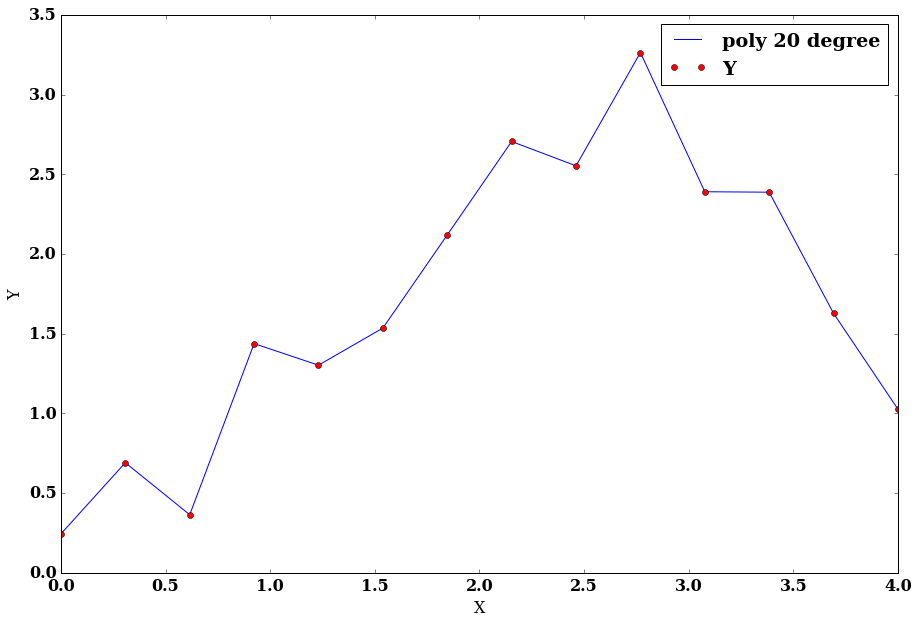

In [344]:
interact(plotit1, degrees=(1,20,1))

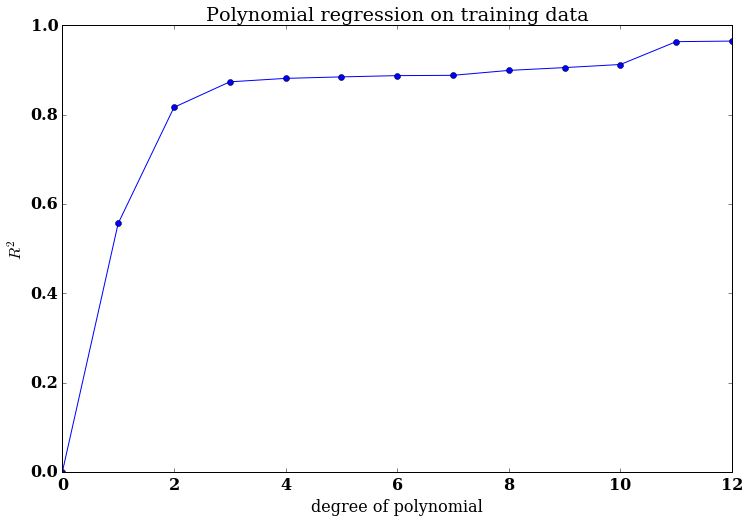

In [345]:

plt.figure(figsize=(12,8))
degrees=12
R2 = np.zeros([ degrees+1,1])
 
for d in range(1, degrees +1):
    model_results, _= polynomial_regression_fit(X_train,Y_train, d)
    R2[d] = model_results.rsquared


plt.plot(R2, 'bo-')
plt.xlabel('degree of polynomial'); plt.ylabel(r'$R^2$')
plt.title('Polynomial regression on training data')

## Polynomial fit (more) 

We will split the data into train/test and fit on train and try on test.

Lets try the fit on test set. 



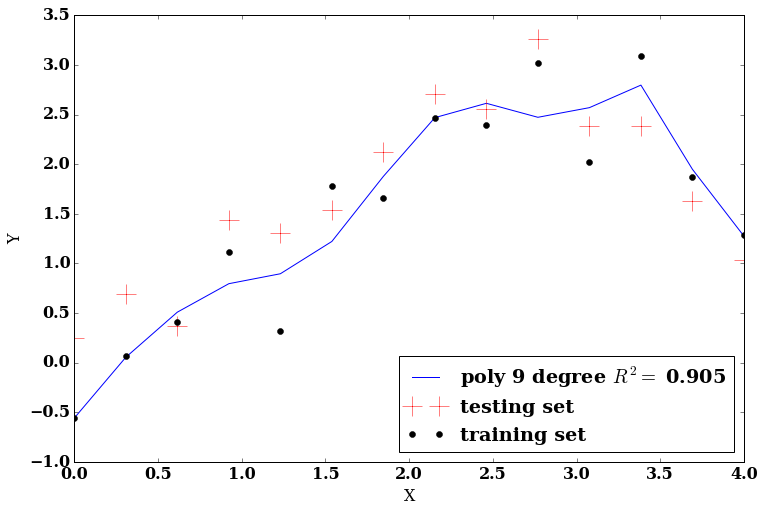

In [378]:
@interact(degrees=(1,20,1))
def plotit(degrees=1):
    plt.figure(figsize=(12,8))
    
    model_results, x_poly= polynomial_regression_fit(X_train,Y_train, degrees)
    y_hat=np.dot(model_results.params,x_poly.T)
    plt.plot(X_test,y_hat, 'b', label='poly '+str(degrees) + ' degree' + r' $R^2=$ ' +
                     str(np.around(model_results.rsquared,3) ))
    plt.plot(X_test,Y_test, 'r+', markersize=20, label='testing set')
    plt.plot(X_train,Y_train, 'ko', label='training set')
    plt.xlabel('X'); plt.ylabel('Y')
    plt.legend(loc='best')

### Examine the $R^2$ as a function of degree for the test and train 



In [332]:



data = pd.read_csv('Lect5_poly1_train.csv')
#data = pd.read_csv('Lect5_poly1_train_small.csv')
X_train = data['X']
Y_train = data['Y']

data = pd.read_csv('Lect5_poly1_test.csv')
#data = pd.read_csv('Lect5_poly1_test_small.csv')
X_test = data['X']
Y_test = data['Y']

In [333]:
degrees=20
R2_test = np.zeros([ degrees+1,1])
R2 = np.zeros([ degrees+1,1])
AIC = np.zeros([ degrees+1,1])
BIC = np.zeros([ degrees+1,1])
R2adj = np.zeros([ degrees+1,1])

for d in range(1, degrees +1):
    model_results, _ = polynomial_regression_fit(X_train,Y_train, d)
    R2[d] = model_results.rsquared
    
    y_hat=polynomial_regression_predict(model_results.params, d, X_test)
    RSS = np.sum((Y_test-y_hat)**2)
    TSS = np.sum((Y_test-np.mean(Y_test))**2)
    R2_test[d] = 1.0-RSS/TSS
    AIC[d] = model_results.aic
    BIC[d] = model_results.bic
    R2adj[d]=model_results.rsquared_adj
    

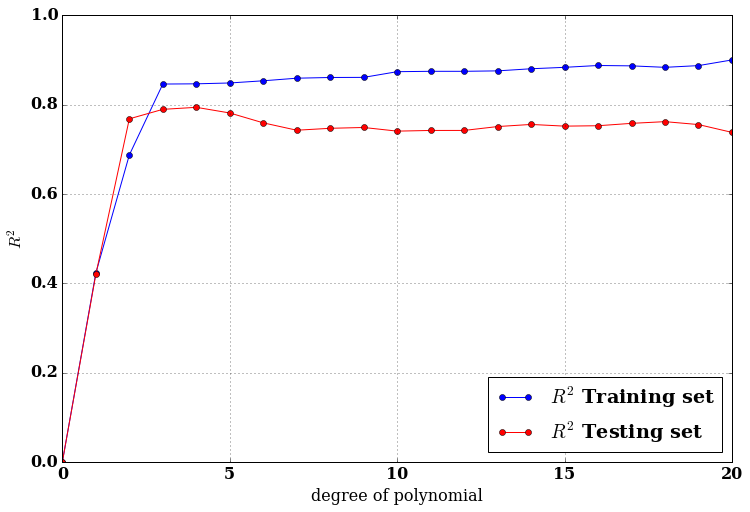

In [334]:
plt.figure(figsize=(12,8))
plt.plot(R2, 'bo-', label=r'$R^2$ Training set')
plt.plot(R2_test, 'ro-', label=r'$R^2$ Testing set')
plt.xlabel('degree of polynomial'); plt.ylabel(r'$R^2$')
plt.xlabel('degree of polynomial'); plt.ylabel(r'$R^2$')
plt.legend(loc='best')
plt.grid()

### Also lets look at AIC etc 

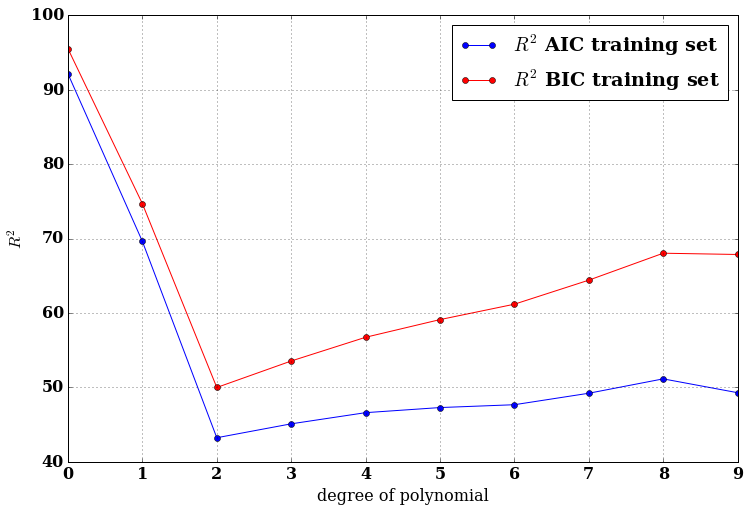

In [335]:
plt.figure(figsize=(12,8))
plt.plot(AIC[1:11], 'bo-', label=r'$R^2$ AIC training set')
plt.plot(BIC[1:11], 'ro-', label=r'$R^2$ BIC training set')
#plt.plot(R2adj, 'bo-', label=r'$R^2$ Training set')

plt.xlabel('degree of polynomial'); plt.ylabel(r'$R^2$')
plt.xlabel('degree of polynomial'); plt.ylabel(r'$R^2$')
plt.legend(loc='best')
plt.grid()

In [372]:
#plt.figure(figsize=(12,8))

#plt.plot(R2adj, 'bo-', label=r'$R^2$ Training set')

#plt.xlabel('degree of polynomial'); plt.ylabel(r'$R^2$')
#plt.xlabel('degree of polynomial'); plt.ylabel(r'$R^2$')
#plt.legend(loc='best')
#plt.grid()

In [337]:
model_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     16.11
Date:                Wed, 21 Sep 2016   Prob (F-statistic):           3.87e-09
Time:                        11:16:48   Log-Likelihood:                -8.9641
No. Observations:                  40   AIC:                             47.93
Df Residuals:                      25   BIC:                             73.26
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3063      0.374      0.819      0.421        -0.464     1.077
x1            11.2977      7.374      1.532      0.138        -3.890    26.485
x2           -87.4606     41.993     -2.083      0.048      -173.947    -0.974
x3           201.1314     83.119      2.420      0.023        29.945   372.318
x4           -99.7930     37.976     -2.628      0.014      -178.006   -21.580
x5          -135.1708     54.433     -2.483      0.020      -247.277   -23.064
x6            52.8870     21.694      2.438      0.022         8.208    97.566
x7           133.5371     51.886      2.574      0.016        26.676   240.398
x8             2.1094      9.516      0.222      0.826       -17.489    21.708
x9          -123.9940     47.987     -2.584      0.016      -222.825   -25.163
x10          -29.4604     13.568     -2.171      0.040       -57.405    -1.516
x11          121.2505     47.186      2.570      0.017        24.069   218.432
x12            5.5797      6.391      0.873      0.391        -7.582    18.741
x13         -128.7955     50.143     -2.569      0.017      -232.067   -25.524
x14          123.1873     48.556      2.537      0.018        23.185   223.189
x15          -61.8023     24.681     -2.504      0.019      -112.634   -10.971
x16           19.3820      7.844      2.471      0.021         3.227    35.537
x17           -3.9453      1.618     -2.438      0.022        -7.278    -0.612
x18            0.5097      0.212      2.405      0.024         0.073     0.946
x19           -0.0381      0.016     -2.372      0.026        -0.071    -0.005
x20            0.0013      0.001      2.340      0.028         0.000     0.002
==============================================================================
Omnibus:                       18.559   Durbin-Watson:                   2.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.561
Skew:                           1.346   Prob(JB):                     1.71e-06
Kurtosis:                       5.949   Cond. No.                     3.20e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.94e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<br>

# Outline 
- Select among multiple predictors 
    - Forward, Backward, Hybrid
    - AIC, BIC, reduced R2, Cp  
- Polynomial regression 
    - Formalism 
    - Select the degree 
    
- Interaction terms 

- ** Revisit SE, p-value and all that jazz  ** 
   

    


## Standard error

We have learned how to calculate the standard error using the formula given to you. These formulas hold only in the case when the error distribution is iid and normal. 
This is not the case in many real world applications
1. Errors sometimes have fatter tails 
2. Errors is not constant 
3. Correlated errors 

What is an alternative way of calculating the SE and from that the p-value and confidence intervals? 



### P-value revisited 


## Standard error (cont) 

Recall that the estimates are not biased, i.e. if we had infinite measurements the SE$\rightarrow$0. 
However, we have only a limited set of measurements, our dataset we are working on. 
From that, we can estimate the coefficients and we can estimate the errors on these estimates. 

Now, imagine that we could access parallel universes and perform the same measurement multiple times. In this scenario, we will have multiple set of data and since these universes are identical we will have a sample of datasets derived from  identical systems (just different universes), i.e. same distributions. These measurements are not identical because every time we make a measurement there is an error.  

We could then estimate the coefficients for each of these datasets and then use those estimates to calculate the ensemble standard deviation (ensemble here means the collection of datasets from all the universes). The standard deviation across universes should be the same (or similar) to the SE estimated with the formula. 


<img src="parallel.jpeg", style="height:400px">


Unfortunately we do not have access to such parallel universes. 

What can we do? 





# think for a minute 
{{countdown(1)}}

The power of simulation: 

   - Select $q$ random subsamples of size $q$ out of the whole dataset
   - Subsample with replacement 
   - For each subsample we estimate the coefficients $\beta$ 
   - From this  collection of $\beta$'s we can estimate SE, confidence intervals etc

In [368]:
def plotSE():
    # Load train set
    data = pd.read_csv("maxheartrate.csv") 

    x = data['age'].values
    y = data['maxheartrate'].values

    # Size of the data set
    n = x.shape[0]

    # set the subsample size 
    subsample_size = 300

    # No. of subsamples
    num_samples = 200

    ### Linear regression 

    # Create a n  array to store coefficients for all subsamples
    coefs_a = np.zeros((num_samples, 2))


    for i in range(num_samples):
        # Generate a random subsample of 50 data points
        perm = np.random.permutation(n) # Generate a list of indices 0 to n and permute it
        x_subsample = x[perm[:subsample_size]] # Get x-vals for the first 50 indices in permuted list

        y_subsample = y[perm[:subsample_size]] # Get y-vals for the first 50 indices in permuted list

        # Fit linear regression model on subsample
        xt= sm.add_constant(x_subsample)
        model = sm.OLS( y_subsample, xt)
        model_results= model.fit()

        # Store the coefficient for the model we obtain
        coefs_a[i, :] = model_results.params


    # Plot histogram of coefficients, and report their confidence intervals 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Repeat for each coefficient
    for j in range(2):
        # Compute mean for the j-th coefficent from subsamples
        coef_j_mean = np.mean(coefs_a[:, j])

        # Compute confidence interval at 95% confidence level (use formula!)
        conf_int_left = np.percentile(coefs_a[:, j], 2.5)
        conf_int_right = np.percentile(coefs_a[:, j], 97.5)
        print('SE'+ r' beta_'+str(j) +' =', np.mean(coef_j_mean.mean()-conf_int_left) /2) 
        # Plot histogram of coefficient values
        axes[j].hist(coefs_a[:, j], alpha=0.5)

        # Plot vertical lines at mean and left, right extremes of confidence interval
        axes[j].axvline(x = coef_j_mean, linewidth=3)
        axes[j].axvline(x = conf_int_left, linewidth=1, c='r')
        axes[j].axvline(x = conf_int_right, linewidth=1, c='r')

        # Set plot labels
        axes[j].set_title('[' + str(round(conf_int_left, 4)) 
                          + ', ' 
                          + str(round(conf_int_right, 4)) + ']')
        axes[j].set_xlabel('Predictor ' + str(j + 1))
        axes[j].set_ylabel('Frequency')

    plt.show()

SE beta_0 = 1.53106658048
SE beta_1 = 0.0295703595635


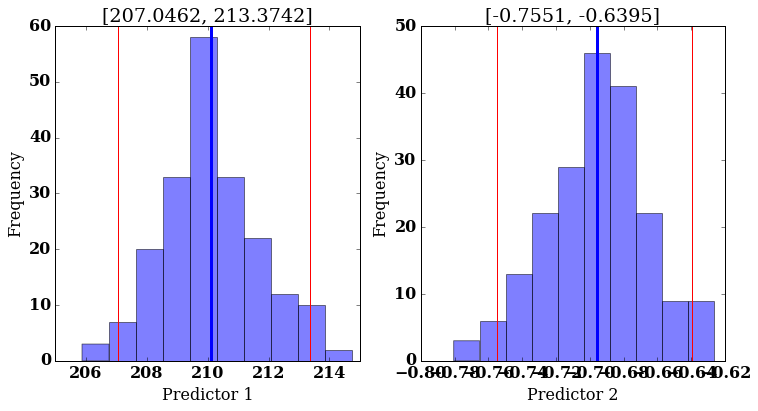

In [369]:
plotSE()

### Compare to SE formulas we discussed in class 

- Calculate the SE using the formula 

    filename: `maxheartrate.csv`


$$SE(\hat{\beta}_0)^2 = \sigma^2 \left[ \frac{1}{n} + \frac{\bar{x}^2}{\sum_i(x_i-\bar{x})^2} \right]$$

$$SE(\hat{\beta}_1)^2 =  \frac{ \sigma^2}{\sum_i(x_i-\bar{x})^2}$$


$$\sigma \approx RSE = \sqrt{ \frac{RSS}{n-2}} $$

$$RSS  = \sum_i ( y_i - \hat{y_i} )^2 = \sum_i \,e_i^2$$
